# Лабораторная работа 1
## Линейные модели

Попробуем реализовать линейные классификаторы и применить их к набору данных, рассматренному в прошлой работе.

Напомню, что мы решаем задачу выявления пациентов с высоким риском сердечного приступа.

### Подготовка данных

In [1]:
import pandas as pd
import pickle

In [2]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [3]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
numerical_features = ['MentHlth', 'PhysHlth', 'BMI']
target = 'HeartDiseaseorAttack'
categorical_features = [feat for feat in list(df.columns) if feat != target and feat not in numerical_features]

Подготовим пайплайн обработки данных.  
Категориальные фичи преобразуем с помощью ohe. Причем если признак бинарный, то будем оставлять только один столбец для него.  Количественные фичи нормализуем. У фичи BMI распределение нормальное, поэтому приведем его к стандартному нормальному, вычтя матожидание и поделив на стандартное отклонение. Остальные количественные фичи приведем к интервалу [0; 1]

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin

In [6]:
data_preprocessing = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), categorical_features),
    ('stdscale', StandardScaler(), ['BMI']),
    ('minmax', MinMaxScaler(), [feat for feat in numerical_features if feat != 'BMI'])
])

ColumnTransformer возвращает разреженную матрицу. Мы хотим сделать ее нормальной, чтобы ее можно было передавать дальше по пайплайну в модель. Поэтому напишем свой трансформер, который превращает разреженную матрицу в обычный массив.

In [7]:
class ToArrayTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

Поделим данные на трейн и тест

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop(target, axis=1)
y = df[target]
assert len(X) == len(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0xDEAD)

In [11]:
X_train.shape, X_test.shape

((202944, 21), (50736, 21))

### Подсчет метрик

Хотим для каждой модели посчитать:
* Accuracy
* Precision
* Recall
* ROC AUC
* Confusion Matrix

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

In [13]:
def get_metrics(model, X, y_true, threshold=0.5, use_probas=True):
    
    if use_probas:
        y_pred_probas = model.predict_proba(X)
        if len(y_pred_probas.shape) == 2:
            y_pred_probas = y_pred_probas[:, 1] 
        y_pred = y_pred_probas > threshold
    else:
        y_pred = model.predict(X)
    
    print('Accuracy = ', accuracy_score(y_true, y_pred))
    print('Precision = ', precision_score(y_true, y_pred))
    print('Recall = ', recall_score(y_true, y_pred))
    if use_probas:
        print('ROC AUC = ', roc_auc_score(y_true, y_pred_probas))
    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))
    
    if use_probas:
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probas)
        plt.figure(figsize=(15, 8))
        plt.xlabel('Recall')
        plt.ylabel('Presicion')
        plt.title('Precision-recall curve')
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.grid()
        plt.plot(recall, precision)

Помним про то, что у нас очень несбалансированные классы (91% vs 9%). Поэтому трешхолд 0.5 не всегда будет оптимален для нашей задачи. Поэтому будем строить дополнительно precison-recall кривую, чтобы оценить зависимость пресижена от реколла.

Также учитываем, что в этой задаче нам важно не упустить больных пациентов, поэтому будем стремиться максимизировать реколл.

Установим отметку реколла = 0.7 и будем сравнивать модели при таком реколле.

### KNN

In [28]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

In [38]:
from sklearn.metrics import euclidean_distances

class MyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        # check equal shapes
        X, y = check_X_y(X, y)
        
        # remember x and y
        self.X = X
        self.y = y
        
        return self
    
    def predict_proba(self, X):
        """
        Get P(y == 1 | X)
        """
        # check that X is a correct array
        X = check_array(X)
        
        y = np.ndarray((X.shape[0]))
        for i, elem in enumerate(X):
            # get distances and labels
            distances = euclidean_distances([elem], self.X)[0]
            distances_with_labels = np.stack((distances, self.y), axis=1)
            distances_with_labels.sort(axis=0)
            
            # get k nearest neighbors and count their labels
            k_neighbors = distances_with_labels[:self.n_neighbors]
            labels, counts = np.unique(k_neighbors[:, 1], return_counts=True)
            for j, label in enumerate(labels):
                if label == 1:
                    proba1 = counts[j] / self.n_neighbors
                    break
            else:
                # no neighbors with label = 1
                proba1 = 0
            y[i] = proba1
            
        return y
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) > threshold

In [39]:
knn_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('knn', MyKNN())
    ]
)

In [44]:
knn_my_gs = GridSearchCV(knn_my, {'knn__n_neighbors': [1, 3, 5, 7]})
knn_my_gs.fit(X_train, y_train);

In [45]:
knn_my_gs.best_params_

{'knn__n_neighbors': 7}

Accuracy =  0.8973509933774835
Precision =  0.37682165163081194
Recall =  0.1118895528539048
ROC AUC =  0.7442772663080971
Confusion matrix:
[[44985   898]
 [ 4310   543]]


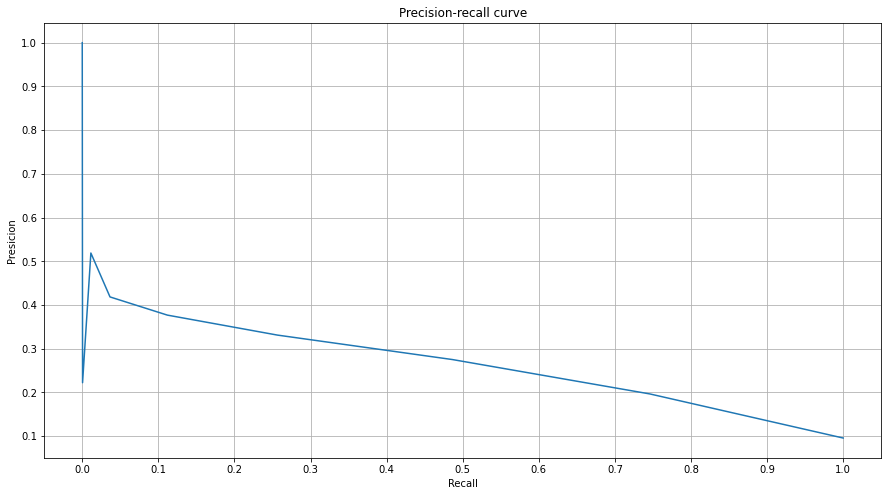

In [46]:
get_metrics(knn_my_gs, X_test, y_test, threshold=0.5)

*КНН очень долго работает, поэтому я не стал подбирать тут порог для реколла 0.7. По кривой видно, что пресижен в таком случае будет примерно 0.21*

In [47]:
f = open("knn.pkl", "wb")
pickle.dump(knn_my_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

Sklearn:

In [84]:
from sklearn.neighbors import KNeighborsClassifier

knn_sk = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('knn', KNeighborsClassifier())
    ]
)

In [85]:
knn_sk_gs = GridSearchCV(knn_sk, {'knn__n_neighbors': [1, 3, 5, 7]})
knn_sk_gs.fit(X_train, y_train);

In [86]:
knn_sk_gs.best_params_

{'knn__n_neighbors': 7}

Accuracy =  0.8974495427309996
Precision =  0.37745098039215685
Recall =  0.11106532042035853
ROC AUC =  0.7456294319833972
Confusion matrix:
[[44994   889]
 [ 4314   539]]


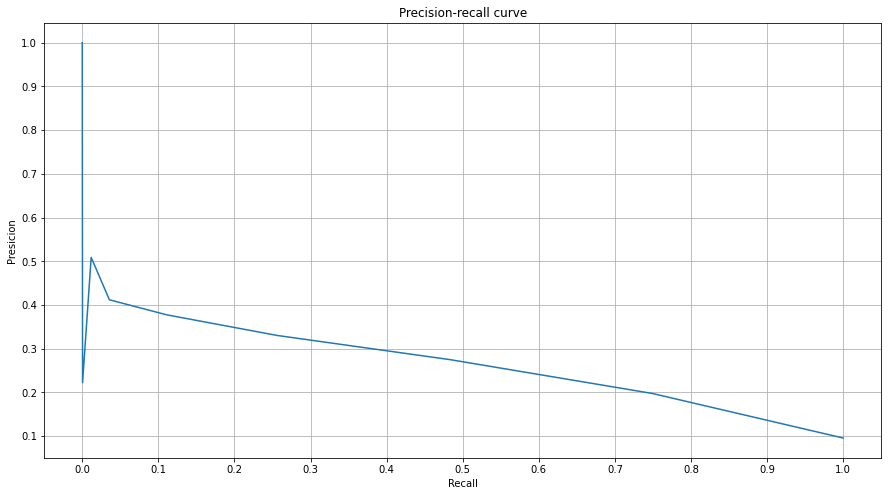

In [87]:
get_metrics(knn_sk_gs, X_test, y_test, threshold=0.5)

In [88]:
f = open("knn_sklearn.pkl", "wb")
pickle.dump(knn_sk_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Логистическая регрессия

Саму регрессию можно реализовать несколькими способами: аналитически (через метод наименьших квадратов), численно (через градиентный спуск) и еще кучей разных алгоритмов. Я реализую регрессию через стохастический градиентный спуск.

In [16]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=10, lr=0.1, batch_size=256):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n, k = X.shape
        
        if self.w is None:
            np.random.seed(0xDEAD)
            # weights
            self.w = np.random.randn(k + 1)

        X = np.concatenate((np.ones((n, 1)), X), axis=1)  # add bias as feature
        for i in range(self.epochs):
            for j in range(0, len(X), self.batch_size):
                X_batch = X[j:j+self.batch_size]
                y_batch = y[j:j+self.batch_size]
                
                y_pred = self._predict_proba_internal(X_batch)
                self.w -= self.lr * self._get_gradient(X_batch, y_batch, y_pred)

        return self
    
    def _get_gradient(self, X_batch, y_batch, y_pred):
        """
        Get gradient for logistic regression
        """
        gradient = X_batch.T @ (y_pred - y_batch)
        return gradient
        
    def predict_proba(self, X):
        X = check_array(X)
        
        n = X.shape[0]
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        return self._sigmoid(np.dot(X, self.w))

    def _predict_proba_internal(self, X): 
        """
        This function is similar to predict_proba, but we don't concatenate bias here.
        It is used for fitting.
        """
        return self._sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) > threshold
    
    def _sigmoid(self, a):
        return 1. / (1 + np.exp(-a))

In [17]:
logreg_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('logreg', MyLogisticRegression())
    ]
)

In [20]:
logreg_my_gs = GridSearchCV(logreg_my, {'logreg__lr': [0.001, 0.01, 0.05, 0.1,], 'logreg__epochs': [10, 20, 30, 40]})
logreg_my_gs.fit(X_train, y_train);

In [21]:
logreg_my_gs.best_params_

{'logreg__epochs': 40, 'logreg__lr': 0.001}

Accuracy =  0.805424156417534
Precision =  0.2876723919113292
Recall =  0.7005975685143211
ROC AUC =  0.8487811092314154
Confusion matrix:
[[37464  8419]
 [ 1453  3400]]


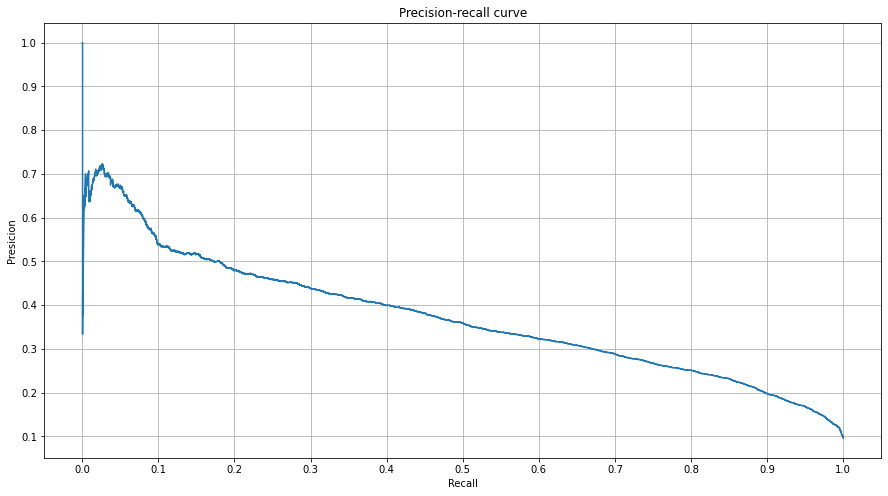

In [59]:
get_metrics(logreg_my_gs, X_test, y_test, threshold=0.129)

In [23]:
f = open("logreg.pkl", "wb")
pickle.dump(logreg_my_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

Sklearn:

В гридсерче будем пробовать добавлять регуляризацию модели и менять коэффициент при регуляризации

In [19]:
from sklearn.linear_model import LogisticRegression

logreg_sk = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('logreg', LogisticRegression(class_weight='balanced'))
    ]
)

In [25]:
logreg_sk_gs = GridSearchCV(logreg_sk, {'logreg__penalty': ['none', 'l2'], 'logreg__C': [0.01, 0.1, 1, 10]})
logreg_sk_gs.fit(X_train, y_train);

C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore

C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\moise\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
logreg_sk_gs.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2'}

Accuracy =  0.8040050457269
Precision =  0.28600252206809584
Recall =  0.7010096847310942
ROC AUC =  0.8490984305448075
Confusion matrix:
[[37390  8493]
 [ 1451  3402]]


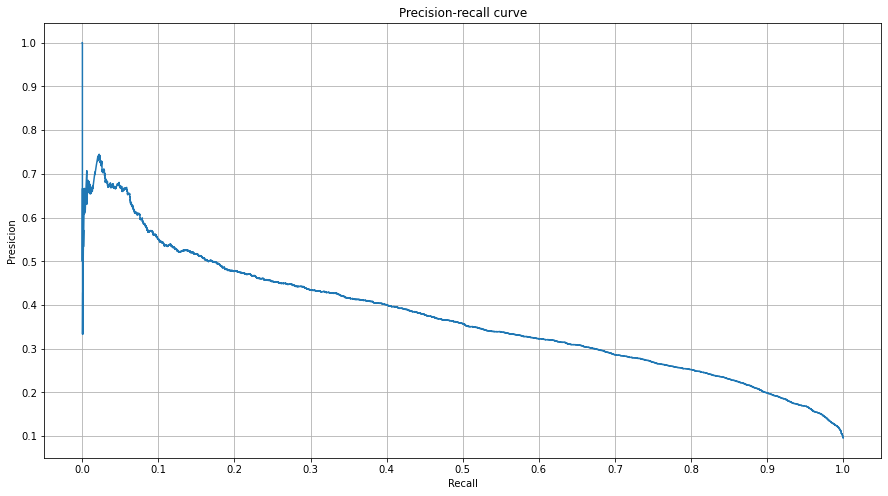

In [48]:
get_metrics(logreg_sk_gs, X_test, y_test, threshold=0.588)

In [38]:
f = open("logreg_sklearn.pkl", "wb")
pickle.dump(logreg_sk_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

Для склерновской модели я брал другие пороги, потому что здесь при обучении я использовал веса для баланса классов.

### Naive Bayes

Реализуем наивный алгоритм Байеса. Наивность заключается в предположении о нормальном распределении фичей.

In [18]:
class MyNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        labels, counts = np.unique(y, return_counts=True)
        self.labels = labels
        # remember frequencies, means and standart deviations. we'll need it in bayes theorem
        self.freq = np.array([cnt / y.shape[0] for cnt in counts])
        self.means = np.array([X[y == label].mean(axis = 0) for label in labels])
        self.stds = np.array([X[y == label].std(axis = 0) for label in labels])

        return self
    
    def predict_proba(self, X):
        X = check_array(X)
        y = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            cur_freq = np.array(self.freq)
            for j in range(len(self.labels)):
                # P(label[j]|X)
                p = np.array([self._gaussian(self.means[j][k], self.stds[j][k], x[k]) for k in range(X.shape[1])])
                cur_freq[j] *= np.prod(p)
            y[i] = cur_freq[1]
        return y
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) > threshold
    
    def _gaussian(self, mu, sigma, x0):
        # X ~ N(mu, sigma)
        # counts F(x0), where F is distribution function
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * np.pi * sigma)

In [19]:
nb_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('nb', MyNaiveBayes())
    ]
)

Гридсерчить тут нечего, будем запускать так.

In [31]:
nb_my.fit(X_train, y_train);

Accuracy =  0.49032245348470516
Precision =  0.12319724474420607
Recall =  0.7076035441994643
ROC AUC =  0.6323003892406815
Confusion matrix:
[[21443 24440]
 [ 1419  3434]]


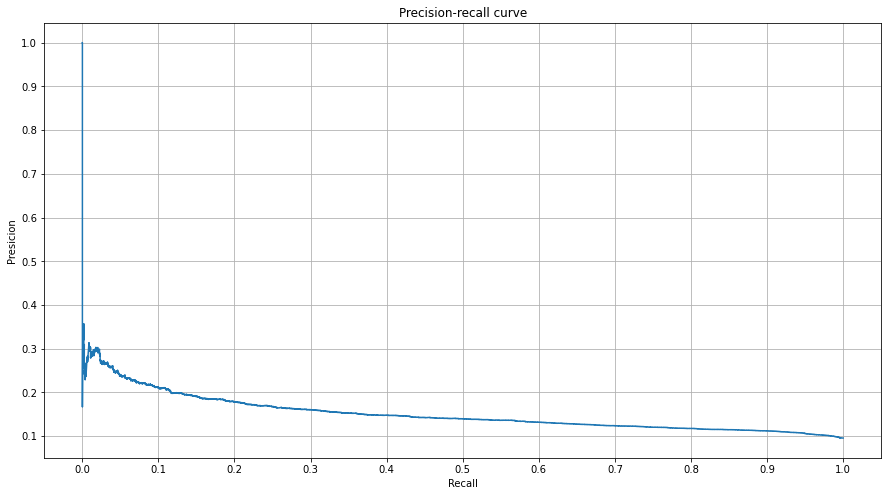

In [81]:
get_metrics(nb_my, X_test, y_test, threshold=7e-12)

In [34]:
f = open("nb.pkl", "wb")
pickle.dump(nb_my, f, pickle.HIGHEST_PROTOCOL)
f.close()

Sklearn:

In [35]:
from sklearn.naive_bayes import GaussianNB

nb_sk = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('nb', GaussianNB())
    ]
)
nb_sk.fit(X_train, y_train);

Accuracy =  0.7574306212551246
Precision =  0.2386762024961436
Recall =  0.7014218009478673
ROC AUC =  0.8120096618766662
Confusion matrix:
[[35025 10858]
 [ 1449  3404]]


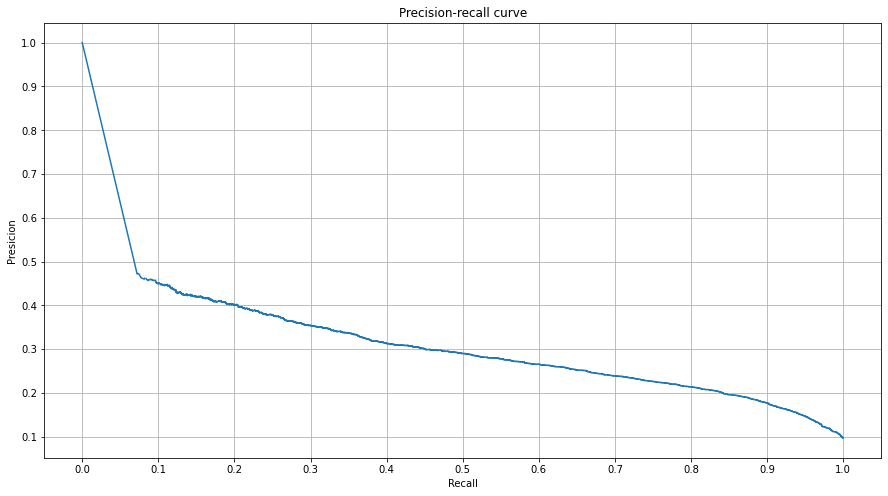

In [67]:
get_metrics(nb_sk, X_test, y_test, threshold=0.93)

In [37]:
f = open("nb_sklearn.pkl", "wb")
pickle.dump(nb_sk, f, pickle.HIGHEST_PROTOCOL)
f.close()

Мой наивный байес оказался похуже реализации склерна. Возможно, в склерне вместо произведения вероятностей используется минус сумма их логарифмов.

### SVM

In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
class MySVM(ClassifierMixin, BaseEstimator):
    def __init__(self, epochs=10, lr=0.1, alpha=0.1):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.alpha = alpha  # regularization parameter
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        y = np.where(y == 1, 1, -1)
        n, k = X.shape
        
        if self.w is None:
            np.random.seed(0xDEAD)
            # weights
            self.w = np.random.randn(k + 1)

        X = np.concatenate((np.ones((n, 1)), X), axis=1)  # add bias as feature
        for i in range(self.epochs):
            for j, x in enumerate(X):
                margin = y[j] * np.dot(self.w, x)
                if margin >= 1:
                    self.w -= self.lr * self.alpha * self.w / self.epochs
                else:
                    self.w += self.lr * (y[j] * x - self.alpha * self.w / self.epochs)
        return self
    
    def predict(self, X):
        # no predict proba here
        X = check_array(X)
        n, k = X.shape
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        y = np.ndarray((n))
        
        for i, elem in enumerate(X):
            prediction = np.dot(self.w, elem)
            if prediction > 0:
                y[i] = 1
            else:
                y[i] = 0
        return y
    
    
    def _hinge_loss(self, x, y):
        return max(0, 1 - y * np.dot(x, self.w))
    
    
    def _soft_margin_loss(self, x, y):
        return self._hinge_loss(x, y) + self.alpha * np.dot(self.w, self.w)

In [24]:
svm_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('svm', MySVM())
    ]
)

In [25]:
svm_my_gs = RandomizedSearchCV(svm_my, {'svm__lr': [0.001, 0.01, 0.05, 0.1,],
                                  'svm__epochs': [10, 20, 30, 40],
                                  'svm__alpha': [0.01, 0.1, 1, 10]})
svm_my_gs.fit(X_train, y_train);

In [26]:
svm_my_gs.best_params_

{'svm__lr': 0.001, 'svm__epochs': 40, 'svm__alpha': 10}

In [27]:
get_metrics(svm_my_gs, X_test, y_test, use_probas=False)

Accuracy =  0.9043479974771366
Precision =  0.0
Recall =  0.0
Confusion matrix:
[[45883     0]
 [ 4853     0]]


C:\Users\moise\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
f = open("svm.pkl", "wb")
pickle.dump(svm_my_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

Моя реализация СВМ не смогла решить задачу классификации (но сама реализация корректна, я проверил ее на более простом и сбалансированном датасете). Попробуем решить задачу с помощью склерновской реализации. Рассмотрим несколько лоссов и выберем лучший гридсерчем. Также будем использовать веса у классов

Sklearn:

In [127]:
from sklearn.svm import LinearSVC

svm_sk = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('svm', LinearSVC(class_weight='balanced'))
    ]
)

In [128]:
svm_sk_gs = GridSearchCV(svm_sk, {'svm__loss': ['hinge', 'squared_hinge'], 'svm__C': [0.01, 0.1, 1, 10]})
svm_sk_gs.fit(X_train, y_train);

C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\moise\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

In [25]:
svm_sk_gs.best_params_

{'svm__C': 10, 'svm__loss': 'squared_hinge'}

In [26]:
get_metrics(svm_sk_gs, X_test, y_test, use_probas=False)

Accuracy =  0.8185115105644907
Precision =  0.2952515279736718
Recall =  0.6470224603338142
Confusion matrix:
[[38388  7495]
 [ 1713  3140]]


In [27]:
f = open("svm_sklearn.pkl", "wb")
pickle.dump(svm_sk_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()